In [5]:
from openai import OpenAI
import pandas as pd
client = OpenAI()

df = pd.read_csv('idioms.csv')
#df = df.head(6)
def translate_verb(id):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an expert in Moroccan Darija dialect and in translating Darija to English." +
             "Purpose of the translation: To study the accuracy of LLMs on Darija,"
             "Target audience: Darija Computational linguists"
            },
            {"role": "user", "content": "Translate the provided Moroccan Darija dialect idiom into English using literal translation."+
             "You must account for concepts such as articulation and emphasis in Darija and unique verbs to the language." + 
             "No explanations are needed in the output"
             },
            {"role": "assistant", "content": "OK, I understand. I am ready for the translation."},
            {"role": "user", "content":  f"{id}" }
            ], 
            #
        temperature=0.1  # Deterministic responses
        )
    return completion.choices[0].message.content
def CoT_1(arb, translated):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a Computational Linguist expert."},
            {"role": "user", "content": "Check the semantic equivalence of the two provided verbs in Darija and English." + 
             "In case that the verbs are not equivalent: Re-translate the Darija verb to English." + 
             "In the case that they are equivalent output the English verb" +
             "The output must not be an infinitive verb. No explanations are needed in the output"},
            {"role": "assistant", "content": "OK, I understand. I will check your inputs for meaning equivalence." + 
             "In the case that the verbs are not equivalent, I will re-translate the Darija verb to English."+
             "Otherwise, I will output the provided English verb"},
            {"role": "user", "content":  f"{arb} / {translated}" }],
        temperature=0.1  # Deterministic responses 
        )
    return completion.choices[0].message.content
df['transl'] = df['darija_ar'].apply(translate_verb)

#CoT = []
#for arb, eng in zip(df['darija_ar'], df['transl']):
#    translation = CoT_1(arb, eng)
#    CoT.append(translation)

# Create a DataFrame to hold the results
#CoT_df = pd.DataFrame(CoT, columns=['verb'])

# Display or save the resulting DataFrame
print(df['transl'])

0     Go out to eat the tomatoes, come down who told...
1     What do you want, O naked one, you should give...
2     If the peach is the one healing, then it's hea...
3     Not the one who didn't reach the meat, tell he...
4     Don't put your hand in the beehive so that you...
5     Don't put your head in the bran so the chicken...
6     The one who bites the snake is afraid of the r...
7                       He came to put kohl on her eye.
8     "He who doesn't have money, his words are muff...
9     His tail is up like a rooster in the neighbors...
10    Praise your friend in front of people and scol...
11                   Make an eye see and an eye not see
12                                     Make a Mikka eye
13    He doesn't feel the needle except the one he's...
14    The generation is like a pigeon, it neither fe...
15                               Mind your own business
16    The scholar Dahman, read the Quran for seven d...
17                         The owner of the crow

c:\Users\yassi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\yassi\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\yassi\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[(2, 'Go out to eat the tomatoes, come down who told you that.', 'Come upstairs and have some figs, get downstairs who told you so!', 0.5035977363586426, False), (3, 'What do you want, O naked one, you should give me the gold ring, my lord.', 'You! The one naked, what do you need? I need a ring made of gold.', 0.9353286623954773, True), (4, "If the peach is the one healing, then it's healing itself.", 'If peach heals, it would have healed itself.', 0.8666143417358398, True), (5, "Not the one who didn't reach the meat, tell her about the knife.", 'When the cat can’t reach the meat, it says nevermind it stinks anyway.', 0.4941149652004242, False), (6, "Don't put your hand in the beehive so that you don't get stung.", "Don't stick your hand in holes in the ground so that you don't get bitten by snakes.", 0.8809186220169067, True), (7, "Don't put your head in the bran so the chickens don't peck you", "Don't put your face in bran (chicken food) if you don't want to get pecked by the hens.",

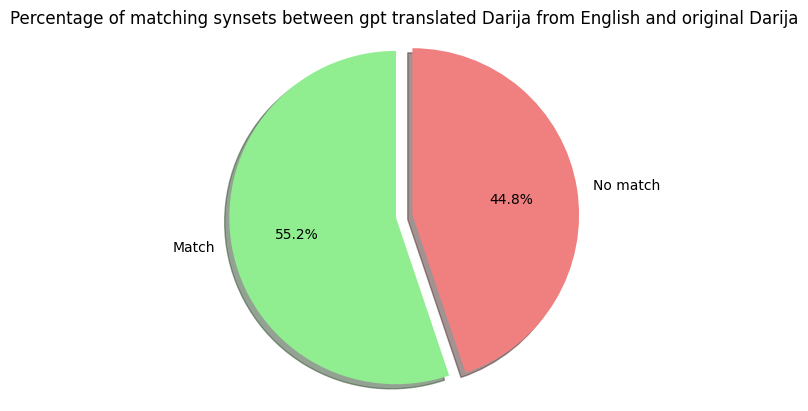

In [6]:
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from sentence_transformers import SentenceTransformer, util

model_name = 'bert-base-nli-mean-tokens'
# Load a pre-trained SentenceTransformer model
model = SentenceTransformer(model_name)


transl = df['transl']
eng = df['literal_eng']

results = []
def evaluate_pairs(transl, eng, threshold=0.7):
    for i in range(len(transl)):
        sentence1, sentence2 = transl[i], eng[i]
        embedding1 = model.encode(sentence1, convert_to_tensor=True)
        embedding2 = model.encode(sentence2, convert_to_tensor=True)
        similarity = util.pytorch_cos_sim(embedding1, embedding2)
        results.append((i+2, sentence1, sentence2, similarity.item(), similarity.item() >= threshold))
    return results
results = evaluate_pairs(transl, eng)
print(results)


# Extract the last element of each tuple in the list (representing True or False values)
last_elements = [result for *_, result in results]

# Count how many comparisons are True
true_count = sum(last_elements)  # True evaluates to 1, so summing directly counts the True values

# Calculate the percentage of True vs False
total_comparisons = len(results)
false_count = total_comparisons - true_count

# Plot pie chart
labels = 'Match', 'No match'
sizes = [true_count, false_count]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentage of matching synsets between gpt translated Darija from English and original Darija")

plt.show()


This basically needs playing with the request.